In [215]:
import numpy as np
import pandas as pd
from sklearn.tree import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import warnings

In [216]:
def import_data():
    wine_data = pd.read_csv('winequality-red.csv', sep=';', header=0)
    print('Dataset Length:', len(wine_data))
    print('Dataset Shape:', wine_data.shape)
    print('Dataset:', wine_data.head())

    return wine_data

In [217]:
def split_dataset(wine_data):
    x = wine_data.values[:, :-1]
    y = wine_data.values[:, -1]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

    return x, y, x_train, x_test, y_train, y_test

In [218]:
def train_using_random_forest(x_train, y_train):
    #Create a random forest classifier
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=100, max_depth=3, min_samples_leaf=5)

    #Train the model
    clf_rf.fit(x_train, y_train)

    return clf_rf

In [219]:
def prediction(x_test, clf_object):
    y_pred = clf_object.predict(x_test)
    print('Predicted Values:')
    print(y_pred)

    return y_pred

In [220]:
def calculate_accuracy(y_test, y_pred):
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Accuracy:', accuracy_score(y_test, y_pred) * 100)
    print('Report', classification_report(y_test, y_pred, zero_division=0))

In [221]:
def plot_random_forest_tree(clf_rf, feature_names, class_names, tree_index=0):
    plt.figure(figsize=(20, 10))
    plot_tree(clf_rf.estimators_[tree_index], feature_names=feature_names,
              class_names=class_names, filled=True, rounded=True)
    plt.show()

Dataset Length: 1599
Dataset Shape: (1599, 12)
Dataset:    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9

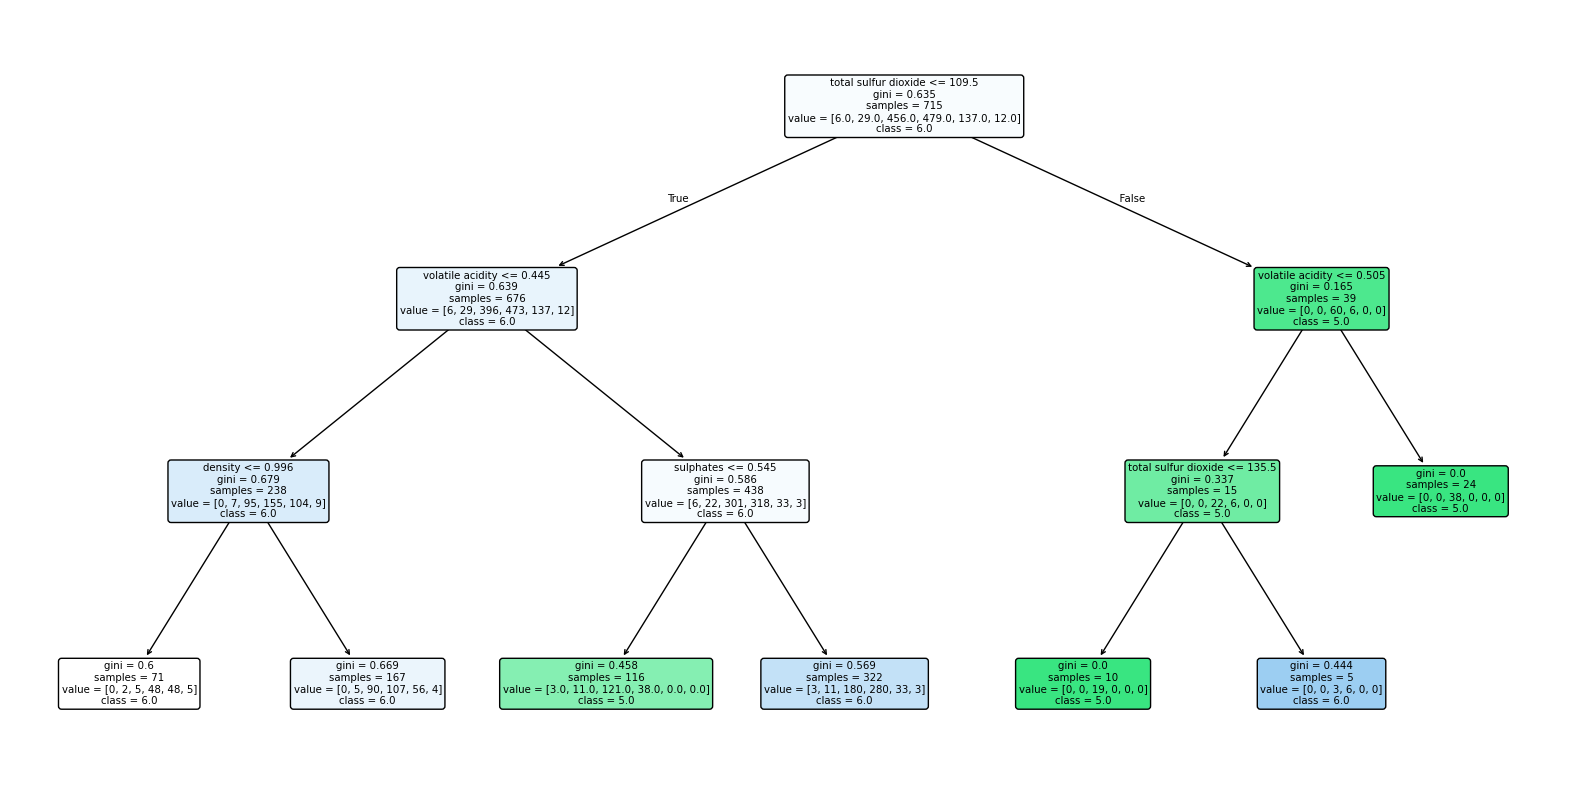

In [222]:
if __name__ == "__main__":
    data = import_data()
    x, y, x_train, x_test, y_train, y_test = split_dataset(data)

    #Train using Random Forest
    clf_rf = train_using_random_forest(x_train, y_train)

    #Predictions
    print('Results using Random Forest:')
    y_pred_rf = prediction(x_test, clf_rf)

    calculate_accuracy(y_test, y_pred_rf)

    feature_names = list(data.columns[:-1])
    class_names = list(map(str, np.unique(y_train)))

    plot_random_forest_tree(clf_rf, feature_names, class_names, tree_index=0)